### Imports and Settings

In [22]:
import matplotlib.pyplot as plt

from ariel.ec.a004 import *

config = EASettings(quiet=True)

## EA operations

- Creating a new individual (NxN chess board)
- Custom evaluation function that suits N-Queens
- Custom mutation function using IntegerMutator.integer_creep(), ensuring no out of bounds Queens
- Custom roulette wheel parent selection
- Custom survivor selection that sorts individuals and selects fittest ones
- Using crossover from ariel.ec.a004 since single-point crossover is the only crossover option in this version of ariel


In [23]:
def create_individual(n: int) -> Individual:
    ind = Individual()
    ind.genotype = IntegersGenerator.integers(low=0, high=n, size=n)
    return ind


def compute_fitness_n_queens(solution: np.ndarray) -> int:
    num_queens = len(solution)
    fitness = 0

    # Loop over each queen and check if it is not attacked by any other queen
    for i in range(num_queens):
        safe = True  # assume the queen is safe until we find a conflict
        for j in range(num_queens):
            if i != j and (solution[i] == solution[j] or abs(solution[i]-solution[j]) == abs(i-j)):
                safe = False
                break  # stop checking if this queen is attacking/attacked
        if safe:
            fitness += 1  # count this queen as non-attacking

    return fitness


def evaluate_population(population: Population) -> Population:
    for ind in population:
        if ind.requires_eval:
            ind.fitness = compute_fitness_n_queens(ind.genotype)

    return population


def n_queens_mutation(population: Population) -> Population:
    for ind in population:
        if ind.tags.get("mut", False):
            genes = cast("list[int]", ind.genotype)
            # Apply creep mutation
            mutated = IntegerMutator.integer_creep(
                individual=genes,
                span=1,
                mutation_probability=0.25,
            )
            # Ensure genes stay within board limits (0..N-1)
            N = len(genes)
            mutated = [max(0, min(N - 1, g)) for g in mutated]

            ind.genotype = mutated
            ind.requires_eval = True
    return population


def sort_survivor_selection(population: Population) -> Population:
    # Sort population by fitness
    population.sort(key=lambda ind: ind.fitness,
                    reverse=config.is_maximisation)

    # Keep only the top N individuals alive
    target_size = config.target_population_size
    for idx, ind in enumerate(population):
        ind.alive = idx < target_size  # top target_size survive

    return population


def roulette_wheel_selection(population: Population) -> Population:
    # Extract fitness values
    fitness_values = np.array([ind.fitness for ind in population], dtype=float)

    total_fitness = fitness_values.sum()

    if total_fitness == 0:
        # If all fitnesses are zero, select randomly
        probabilities = np.ones(len(population)) / len(population)
    else:
        probabilities = fitness_values / total_fitness

    selected_indices = np.random.choice(
        len(population),
        size=len(population),
        replace=True,
        p=probabilities
    )

    # Mark selected parents
    for idx, ind in enumerate(population):
        ind.tags["ps"] = idx in selected_indices

    return population

## Running EA multiple times to get average results

- Here, we do not call ea.run(). Instead, we manually call ea.step() inside a loop in order to store history for latter plotting and analysis.

In [24]:
def run_multiple_ea(n=8, pop_size=100, num_generations=100, runs=10):
    """
    Run the EA multiple times and return the average and std fitness per generation,
    plus the best individual across all runs.
    """
    
    # Storage for all runs
    fitness_over_runs = np.zeros((runs, num_generations))
    best_solutions = []

    for r in range(runs):
        # Create initial population
        population_list = [create_individual(n) for _ in range(pop_size)]
        population_list = evaluate(population_list)

        # Define EA steps
        ops = [
            EAStep("parent_selection", roulette_wheel_selection),
            EAStep("crossover", crossover),
            EAStep("mutation", n_queens_mutation),
            EAStep("evaluation", evaluate_population),
            EAStep("survivor_selection", sort_survivor_selection),
        ]

        # Initialize EA
        ea = BasicEA(
            population_list,
            operations=ops,
            num_of_generations=num_generations,
            quiet=True
        )

        # Track fitness per generation
        fitness_history = []
        for _ in range(num_generations):
            ea.step()
            ea.fetch_population(only_alive=True, already_evaluated=True)
            best_fitness = max(ind.fitness for ind in ea.population)
            fitness_history.append(best_fitness)

        fitness_over_runs[r, :] = fitness_history

        # Save best solution of this run
        ea.fetch_population(only_alive=True, already_evaluated=True)
        best_solutions.append(max(ea.population, key=lambda ind: ind.fitness))

    # Average and std across runs
    avg_fitness = np.mean(fitness_over_runs, axis=0)
    std_fitness = np.std(fitness_over_runs, axis=0)

    # Overall best solution
    overall_best = max(best_solutions, key=lambda ind: ind.fitness)
    
    return avg_fitness, std_fitness, overall_best


## Plotting functions

In [25]:
def plot_fitness(avg_fitness, std_fitness, n):
    """Plot average fitness with std shading."""
    generations = np.arange(len(avg_fitness))
    plt.plot(generations, avg_fitness, label=f"N={n}")
    plt.fill_between(
        generations,
        avg_fitness - std_fitness,
        avg_fitness + std_fitness,
        alpha=0.2
    )
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Average Fitness over Generations")
    plt.legend()


def plot_chessboard(solution, n):
    """Plot the N-Queens solution as a chessboard."""
    board = np.zeros((n, n))
    # solution.genotype[i] = column of queen in row i
    for row, col in enumerate(solution.genotype):
        board[row, col] = 1

    print(f"Best solution for N={n}: {solution.genotype} with fitness {solution.fitness}"
          )
    plt.figure()
    plt.imshow(board, cmap="coolwarm")
    plt.title(f"N={n} Best Solution")
    plt.axis("off")
    plt.show()

## Run EA for N=8, N=16 and N=32 (Around 6min, scroll down to see plots)

In [27]:
Ns = [8, 16, 32]
runs = 10
num_generations = 200
pop_size = 100

# Store results for later plotting
results = {}

for n in Ns:
    avg_fit, std_fit, best_sol = run_multiple_ea(
        n=n,
        pop_size=pop_size,
        num_generations=num_generations,
        runs=runs
    )
    results[n] = {
        "avg": avg_fit,
        "std": std_fit,
        "best": best_sol,
    }


[17:47:10] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=342848;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=820211;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:47:18] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=692435;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=472983;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:47:29] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=878092;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=99102;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:47:39] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=972324;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=601465;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:47:49] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=366372;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=46911;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:47:59] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=966540;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=398923;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:48:10] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=563575;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=469774;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:48:19] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=279738;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=470469;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:48:29] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=987135;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=681459;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:48:38] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=896293;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=570436;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:48:48] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=374354;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=203151;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:48:58] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=911506;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=798501;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:49:16] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=447648;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=894027;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:49:39] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=718253;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=452599;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:49:51] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=802412;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=697203;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:50:02] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=75041;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=377571;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:50:12] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=66551;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=70749;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:50:22] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=639048;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=899613;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:50:32] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=472626;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=24268;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:50:42] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=15873;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=426232;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:50:52] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=762449;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=776157;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:51:04] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=365843;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=243615;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:51:15] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=45822;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=968230;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:51:27] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=972351;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=476363;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:51:41] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=690496;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=486471;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:51:54] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=128118;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=448756;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:52:07] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=800829;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=567445;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:52:19] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=695269;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=898366;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:52:33] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=379986;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=572568;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

[17:52:46] Database file exists at /home/marv0711/ariel/__data__/database.db!                            ]8;id=251509;file:///home/marv0711/ariel/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=136516;file:///home/marv0711/ariel/src/ariel/ec/a004.py#84\84]8;;\
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

## Presenting Results

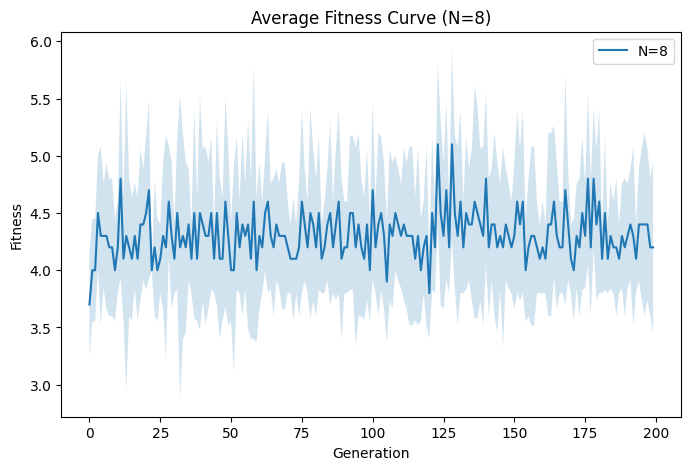

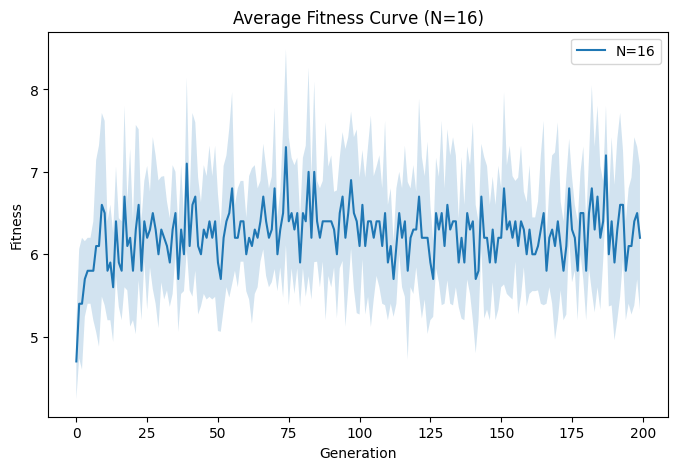

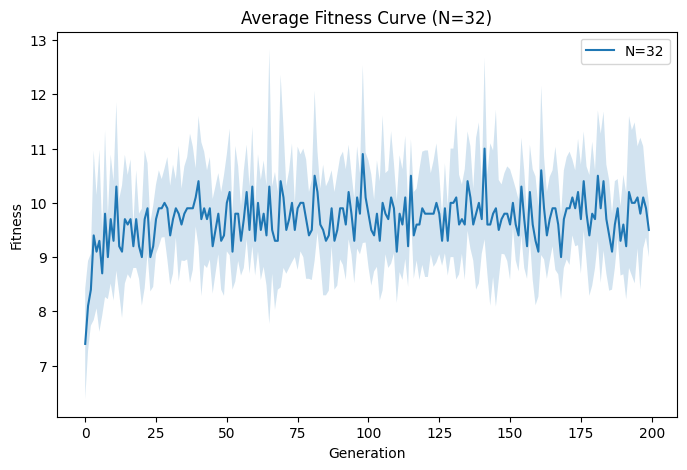

Best solution for N=8: [4, 0, 7, 5, 7, 2, 6, 3] with fitness 6.0


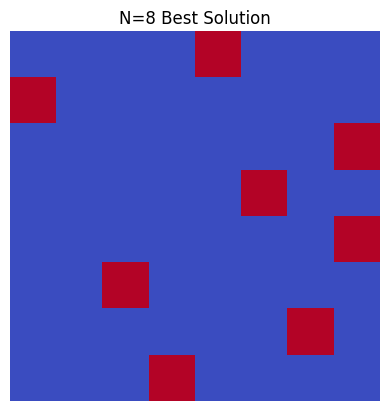

Best solution for N=16: [2, 12, 3, 6, 14, 1, 15, 13, 0, 7, 0, 0, 5, 12, 8, 6] with fitness 8.0


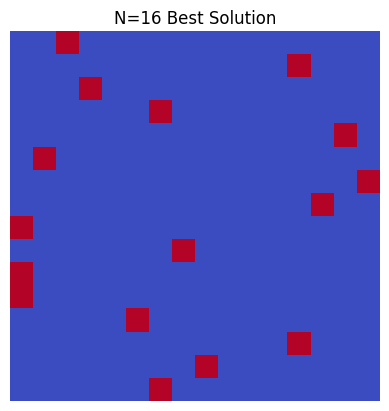

Best solution for N=32: [2, 15, 10, 22, 27, 4, 29, 11, 3, 28, 17, 7, 10, 2, 25, 11, 12, 27, 7, 5, 1, 12, 30, 26, 21, 2, 31, 6, 16, 9, 11, 23] with fitness 10.0


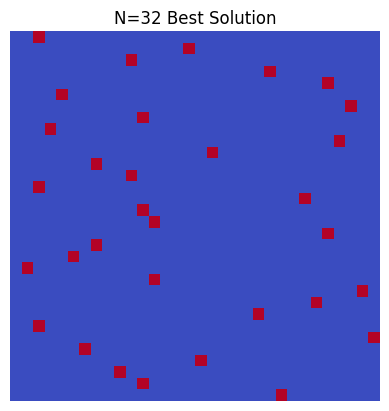

In [ ]:
# Plot average + std fitness curves separately
for n, res in results.items():
    plt.figure(figsize=(8, 5))
    plot_fitness(res["avg"], res["std"], n)
    plt.title(f"Average Fitness Curve (N={n})")
    plt.show()

# Plot best chessboards separately
for n, res in results.items():
    plot_chessboard(res["best"], n)
